### **Import libraries**

In [1]:
import ultralytics 

ultralytics.checks()

Ultralytics 8.3.51  Python-3.10.16 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Setup complete  (20 CPUs, 13.7 GB RAM, 154.3/221.0 GB disk)


In [2]:
import os 
import shutil
import xml.etree.ElementTree as ET 

import yaml 
from sklearn.model_selection import train_test_split 

### **2. Extract Data from XML and Store in YOLO format**

In [3]:
def extract_data_from_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    image_paths = []
    image_sizes = []
    image_labels = []
    bounding_boxes = []

    for image in root:
        bbs_of_image = []
        labels_of_image = []

        for bbs in image.findall("taggedRectangles"):
            for bb in bbs:
                if not bb[0].text.isalnum():
                    continue 

                if "é" in bb[0].text.lower() or "ñ" in bb[0].text.lower():
                    continue 

                bbs_of_image.append( 
                    [ 
                        float(bb.attrib["x"]),
                        float(bb.attrib["y"]), 
                        float(bb.attrib["width"]), 
                        float(bb.attrib["height"]),
                    ]
                ) 
                labels_of_image.append(bb[0].text.lower())

        image_paths.append(image[0].text)
        image_sizes.append((int(image[1].attrib["x"]), int(image[1].attrib["y"])))
        bounding_boxes.append(bbs_of_image)
        image_labels.append(labels_of_image)

    return image_paths, image_sizes, image_labels, bounding_boxes

In [4]:
dataset_dir = "datasets\SceneTrialTrain"
words_xml_path = os.path.join(dataset_dir, "words.xml")
image_paths, image_sizes, image_labels, bounding_boxes = extract_data_from_xml(words_xml_path)

In [5]:
print(f"Number of images: {len(image_paths)}")
print(f"Example image path: {image_paths[0]}")
print(f"Example image size: {image_sizes[0]}")
print(f"Example bounding boxes: {bounding_boxes[0][:2]}")
print(f"Example labels: {image_labels[0][:2]}")

Number of images: 250
Example image path: apanar_06.08.2002/IMG_1261.JPG
Example image size: (1600, 1200)
Example bounding boxes: [[174.0, 392.0, 274.0, 195.0], [512.0, 391.0, 679.0, 183.0]]
Example labels: ['self', 'adhesive']


### **Convert to YOLO format**

In [6]:
def convert_to_yolo_format(image_paths, image_sizes, bounding_boxes):
    yolo_data = []

    for image_path, image_size, bboxes in zip(image_paths, image_sizes, bounding_boxes):
        image_width, image_height = image_size

        yolo_labels = []

        for bbox in bboxes:
            x, y, w, h = bbox 

            center_x = (x + w / 2) / image_width 
            center_y = (y + h / 2) / image_height 
            normalized_width = w / image_width 
            normalized_height = h / image_height

            class_id = 0 

            yolo_label = f"{class_id} {center_x} {center_y} {normalized_width} {normalized_height}"
            yolo_labels.append(yolo_label)

        yolo_data.append((image_path, yolo_labels))
    return yolo_data


In [7]:
print(image_paths)

['apanar_06.08.2002/IMG_1261.JPG', 'apanar_06.08.2002/IMG_1263.JPG', 'apanar_06.08.2002/IMG_1265.JPG', 'apanar_06.08.2002/IMG_1269.JPG', 'apanar_06.08.2002/IMG_1281.JPG', 'apanar_06.08.2002/IMG_1282.JPG', 'apanar_06.08.2002/IMG_1283.JPG', 'apanar_06.08.2002/IMG_1284.JPG', 'apanar_06.08.2002/IMG_1285.JPG', 'apanar_06.08.2002/IMG_1286.JPG', 'apanar_06.08.2002/IMG_1288.JPG', 'apanar_06.08.2002/IMG_1289.JPG', 'apanar_06.08.2002/IMG_1290.JPG', 'apanar_06.08.2002/IMG_1291.JPG', 'apanar_06.08.2002/IMG_1292.JPG', 'apanar_06.08.2002/IMG_1293.JPG', 'apanar_06.08.2002/IMG_1294.JPG', 'apanar_06.08.2002/IMG_1298.JPG', 'apanar_06.08.2002/IMG_1299.JPG', 'apanar_06.08.2002/IMG_1300.JPG', 'apanar_06.08.2002/IMG_1301.JPG', 'apanar_06.08.2002/IMG_1302.JPG', 'apanar_06.08.2002/IMG_1303.JPG', 'apanar_06.08.2002/IMG_1304.JPG', 'apanar_06.08.2002/Img_1305.jpg', 'apanar_06.08.2002/IMG_1306.JPG', 'apanar_06.08.2002/IMG_1307.JPG', 'apanar_06.08.2002/IMG_1308.JPG', 'apanar_06.08.2002/IMG_1311.JPG', 'apanar_06.08

In [8]:
class_labels = ["text"]

yolo_data = convert_to_yolo_format(image_paths, image_sizes, bounding_boxes)

### **4. Train, val, test split**

In [9]:
seed = 0 
val_size = 0.2 
test_size = 0.125 
is_shuffle = True 

train_data, test_data = train_test_split(
    yolo_data, 
    test_size=val_size, 
    random_state=seed, 
    shuffle=is_shuffle,
)

test_data, val_data, = train_test_split(
    test_data, 
    test_size=test_size, 
    random_state=seed, 
    shuffle=is_shuffle
)

### **5. Save data**

In [10]:
def save_data(data, src_img_dir, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    os.makedirs(os.path.join(save_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "labels"), exist_ok=True)

    for image_path, yolo_labels in data:
        shutil.copy(
            os.path.join(src_img_dir, image_path), os.path.join(save_dir, "images")
        )

        image_name = os.path.basename(image_path)
        image_name = os.path.splitext(image_name)[0]

        with open(os.path.join(save_dir, "labels", f"{image_name}.txt"), "w") as f:
            for label in yolo_labels:
                f.write(f"{label}\n")


In [11]:
save_yolo_data_dir = "datasets/yolo_data"
os.makedirs(save_yolo_data_dir, exist_ok=True)
save_train_dir = os.path.join(save_yolo_data_dir, "train")
save_val_dir = os.path.join(save_yolo_data_dir, "val")
save_test_dir = os.path.join(save_yolo_data_dir, "test")

save_data(train_data, dataset_dir, save_train_dir)
save_data(test_data, dataset_dir, save_val_dir)
save_data(val_data, dataset_dir, save_test_dir)

In [ ]:
import os
import yaml

abs_path = os.path.abspath(save_yolo_data_dir)

data_yaml = {
    "path": abs_path,  
    "train": "train/images",  
    "val": "val/images",      
    "test": "test/images",   
    "nc": 1,  
    "names": ["text"]  
}

yolo_yaml_path = os.path.join(abs_path, "data.yml")

os.makedirs(abs_path, exist_ok=True)

with open(yolo_yaml_path, "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False, sort_keys=False)

print(f"✅ Đã tạo file YAML: {yolo_yaml_path}")
print("Nội dung file:")
print(yaml.dump(data_yaml, default_flow_style=False, sort_keys=False))

✅ Đã tạo file YAML: d:\Scene Text Recognition\datasets\yolo_data\data.yml
Nội dung file:
path: d:\Scene Text Recognition\datasets\yolo_data
train: train/images
val: val/images
test: test/images
nc: 1
names:
- text



### **7. Training**

In [ ]:
import ultralytics
import torch
print(ultralytics.__version__)  
print(torch.__version__)        

8.3.51
2.1.0+cu121


In [ ]:
from ultralytics import YOLO
import torch

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

model = YOLO("yolo11n.pt")

model.train(
    data=yolo_yaml_path,
    epochs=100,
    imgsz=640,
    cache=False,  
    workers=0,
    patience=20,
    plots=True,
    device=0,
    batch=16,     
)

New https://pypi.org/project/ultralytics/8.3.146 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.51  Python-3.10.16 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=d:\Scene Text Recognition\datasets\yolo_data\data.yml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=0, project=None, name=train32, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina

train: Scanning D:\Scene Text Recognition\datasets\yolo_data\train\labels.cache... 200 images, 7 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


c:\Users\AMIN\anaconda3\envs\torchenv310\lib\site-packages\ultralytics\data\augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning D:\Scene Text Recognition\datasets\yolo_data\val\labels.cache... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]

Plotting labels to runs\detect\train32\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train32
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.45G      1.891      3.288      1.603         58        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         43        200     0.0125      0.805      0.203      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.39G      1.124      2.176      1.094         73        640: 100%|██████████| 13/13 [00:04<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

                   all         43        200      0.259       0.62      0.465      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.51G      1.206      1.537      1.136         61        640: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         43        200      0.472      0.305      0.299       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.39G      1.167      1.435      1.133         42        640: 100%|██████████| 13/13 [00:03<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.37it/s]

                   all         43        200       0.49      0.375       0.39      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       2.4G      1.203       1.45      1.124         42        640: 100%|██████████| 13/13 [00:03<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

                   all         43        200      0.589      0.455      0.544      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       2.4G      1.212      1.332      1.109        125        640: 100%|██████████| 13/13 [00:03<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.89it/s]

                   all         43        200       0.58      0.665      0.602      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       2.4G      1.155      1.283      1.091         67        640: 100%|██████████| 13/13 [00:03<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

                   all         43        200      0.527      0.675      0.562       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.63G      1.174      1.245      1.086         59        640: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

                   all         43        200      0.642       0.63      0.612      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.39G      1.151      1.238      1.105         91        640: 100%|██████████| 13/13 [00:03<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

                   all         43        200      0.653      0.675      0.702      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       2.4G      1.131      1.201      1.088         95        640: 100%|██████████| 13/13 [00:03<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

                   all         43        200      0.782       0.68      0.743       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       2.4G      1.159      1.155      1.085         44        640: 100%|██████████| 13/13 [00:03<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.77it/s]

                   all         43        200      0.577      0.705      0.633      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       2.4G      1.094      1.086      1.069         72        640: 100%|██████████| 13/13 [00:03<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.66it/s]

                   all         43        200      0.755      0.724      0.753      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       2.5G      1.101      1.105      1.083         40        640: 100%|██████████| 13/13 [00:03<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.93it/s]

                   all         43        200      0.715      0.705      0.732      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       2.4G      1.087      1.102      1.064         37        640: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.61it/s]

                   all         43        200      0.769      0.725      0.766      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.47G      1.095      1.044       1.06         63        640: 100%|██████████| 13/13 [00:03<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

                   all         43        200      0.699        0.8      0.708       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       2.4G      1.047      1.024      1.037         43        640: 100%|██████████| 13/13 [00:03<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

                   all         43        200      0.792      0.735      0.795      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.39G      1.075      1.096      1.068         32        640: 100%|██████████| 13/13 [00:03<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

                   all         43        200      0.855       0.83      0.867      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       2.4G      1.035      1.011      1.042         54        640: 100%|██████████| 13/13 [00:03<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.89it/s]

                   all         43        200      0.866        0.8      0.869      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.47G      1.013     0.9742      1.033         53        640: 100%|██████████| 13/13 [00:03<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

                   all         43        200      0.824      0.819      0.814      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       2.4G      1.038     0.9729       1.03         56        640: 100%|██████████| 13/13 [00:03<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

                   all         43        200      0.833       0.86      0.856      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.39G      1.052     0.9522      1.044         58        640: 100%|██████████| 13/13 [00:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

                   all         43        200      0.833      0.785      0.852        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       2.4G      1.048     0.9671      1.047         63        640: 100%|██████████| 13/13 [00:03<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]

                   all         43        200      0.795      0.796      0.848      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.52G      1.035     0.9376       1.04         50        640: 100%|██████████| 13/13 [00:03<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.76it/s]

                   all         43        200      0.833      0.825      0.837      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       2.4G      1.058     0.9071      1.022         70        640: 100%|██████████| 13/13 [00:03<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

                   all         43        200      0.834      0.852      0.862      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.39G     0.9593     0.8277     0.9977         54        640: 100%|██████████| 13/13 [00:03<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

                   all         43        200      0.865      0.832      0.881      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.64G      1.013     0.8831      1.016         35        640: 100%|██████████| 13/13 [00:03<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

                   all         43        200      0.846       0.86      0.871      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       2.4G     0.9651     0.8609          1         54        640: 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.05it/s]

                   all         43        200      0.843      0.865      0.853      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       2.4G     0.9872     0.8702      1.021         49        640: 100%|██████████| 13/13 [00:03<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

                   all         43        200       0.85        0.8       0.86      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.39G      0.939     0.8285      1.006         65        640: 100%|██████████| 13/13 [00:03<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.91it/s]

                   all         43        200      0.815       0.84      0.865      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.54G      1.008      0.834     0.9984         51        640: 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.839       0.86      0.878      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       2.4G     0.9805     0.8339      1.014         60        640: 100%|██████████| 13/13 [00:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]

                   all         43        200      0.828       0.85       0.84      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       2.4G     0.9871     0.8088      1.003         44        640: 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.77it/s]

                   all         43        200       0.81      0.795      0.829      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.39G     0.9274     0.7844     0.9937         46        640: 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]

                   all         43        200        0.8       0.84       0.85      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       2.4G     0.9544     0.7926     0.9901         57        640: 100%|██████████| 13/13 [00:03<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]

                   all         43        200      0.799       0.84      0.859      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       2.4G     0.9558     0.8175      1.005         59        640: 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]

                   all         43        200      0.861       0.87      0.872       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       2.4G     0.9016      0.782     0.9774         72        640: 100%|██████████| 13/13 [00:03<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

                   all         43        200      0.883       0.88      0.894      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.49G     0.9446     0.7685     0.9786         63        640: 100%|██████████| 13/13 [00:03<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.89it/s]

                   all         43        200      0.843      0.795       0.87      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       2.4G     0.9141     0.7533     0.9781         79        640: 100%|██████████| 13/13 [00:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.79it/s]

                   all         43        200      0.812       0.86      0.848      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       2.4G     0.9374     0.7525     0.9899         87        640: 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

                   all         43        200      0.828      0.864      0.862      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.52G     0.9044     0.7491     0.9894         60        640: 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

                   all         43        200      0.879       0.83      0.886      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.46G     0.9051     0.7412     0.9779         46        640: 100%|██████████| 13/13 [00:03<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

                   all         43        200      0.859       0.85       0.89      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100       2.4G     0.9233     0.7278     0.9889         55        640: 100%|██████████| 13/13 [00:03<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]

                   all         43        200      0.835      0.885      0.892      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       2.4G     0.8868     0.7334     0.9559         52        640: 100%|██████████| 13/13 [00:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.76it/s]

                   all         43        200      0.847       0.85      0.886      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       2.4G     0.9309     0.7302      1.004         53        640: 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.96it/s]

                   all         43        200      0.882       0.87      0.884      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.49G     0.8637     0.6978      0.967         52        640: 100%|██████████| 13/13 [00:03<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]

                   all         43        200      0.855      0.875      0.873      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       2.4G     0.8685     0.6902      0.951         64        640: 100%|██████████| 13/13 [00:03<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]

                   all         43        200      0.865      0.863      0.888       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       2.4G     0.8726     0.7054     0.9701         47        640: 100%|██████████| 13/13 [00:03<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.89it/s]

                   all         43        200      0.866      0.841      0.883      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       2.5G     0.8785     0.6966     0.9717         57        640: 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

                   all         43        200      0.872      0.865      0.895      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.39G     0.8982     0.7019     0.9821         86        640: 100%|██████████| 13/13 [00:03<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

                   all         43        200      0.847      0.855      0.856      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       2.4G     0.8543     0.6755     0.9685         44        640: 100%|██████████| 13/13 [00:03<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

                   all         43        200       0.84      0.865       0.85      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       2.4G     0.8397     0.6675     0.9552         80        640: 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.77it/s]

                   all         43        200       0.88       0.86      0.873      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.48G      0.835      0.671     0.9628         67        640: 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

                   all         43        200      0.901      0.805      0.888      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.39G     0.7989     0.6568     0.9462         57        640: 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.94it/s]

                   all         43        200      0.832      0.845      0.884      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       2.4G     0.8328     0.6565     0.9582         41        640: 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

                   all         43        200      0.896       0.82      0.881      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       2.4G     0.8582     0.6838     0.9702         65        640: 100%|██████████| 13/13 [00:03<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

                   all         43        200      0.848      0.885      0.883       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.47G      0.816     0.6523     0.9541         48        640: 100%|██████████| 13/13 [00:03<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.79it/s]

                   all         43        200      0.831      0.887      0.885      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.39G     0.8187     0.6607     0.9462         48        640: 100%|██████████| 13/13 [00:03<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.78it/s]

                   all         43        200      0.862       0.88      0.885      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       2.4G     0.8223     0.6621     0.9566         43        640: 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

                   all         43        200      0.865      0.875      0.874       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.47G     0.8337     0.6352     0.9515         47        640: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.14it/s]

                   all         43        200       0.89       0.88      0.899      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       2.5G     0.8084     0.6385     0.9545         38        640: 100%|██████████| 13/13 [00:03<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

                   all         43        200      0.898      0.836      0.882       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.39G     0.7791     0.6082     0.9371         87        640: 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]

                   all         43        200      0.855      0.857      0.867      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       2.5G     0.8301     0.6163     0.9495         55        640: 100%|██████████| 13/13 [00:03<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]

                   all         43        200      0.867      0.816      0.867      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.48G     0.8261     0.6214      0.938         44        640: 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]

                   all         43        200      0.845       0.84      0.865      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       2.4G     0.8389     0.6355      0.973         34        640: 100%|██████████| 13/13 [00:03<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.34it/s]

                   all         43        200      0.853      0.835      0.853      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.39G     0.7977     0.6258     0.9508         66        640: 100%|██████████| 13/13 [00:03<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

                   all         43        200      0.846       0.85      0.861      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       2.4G     0.7918     0.6157     0.9332         58        640: 100%|██████████| 13/13 [00:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]

                   all         43        200      0.885      0.855      0.882      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.49G     0.7895     0.5893     0.9452         70        640: 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

                   all         43        200      0.899      0.843      0.883      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.41G     0.7935     0.6067     0.9255         75        640: 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

                   all         43        200      0.885       0.86      0.889      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.39G     0.7483     0.5726     0.9233         60        640: 100%|██████████| 13/13 [00:03<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.93it/s]

                   all         43        200      0.883      0.885      0.887      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       2.4G     0.7805     0.5897      0.932         40        640: 100%|██████████| 13/13 [00:03<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.05it/s]

                   all         43        200      0.879      0.876      0.889      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       2.4G     0.7868     0.5888     0.9295         86        640: 100%|██████████| 13/13 [00:03<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

                   all         43        200      0.862      0.875       0.89      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       2.4G     0.7746     0.5925      0.942         40        640: 100%|██████████| 13/13 [00:03<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.07it/s]

                   all         43        200      0.863      0.885       0.89      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.49G     0.7808     0.6123     0.9381         44        640: 100%|██████████| 13/13 [00:03<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

                   all         43        200      0.897       0.84      0.885      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       2.5G     0.7461     0.5727     0.9194         59        640: 100%|██████████| 13/13 [00:03<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

                   all         43        200      0.894      0.865       0.89      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.49G     0.7518     0.5659     0.9224         76        640: 100%|██████████| 13/13 [00:03<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

                   all         43        200       0.91      0.864      0.892      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       2.4G     0.7849     0.5605     0.9311         65        640: 100%|██████████| 13/13 [00:03<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.91it/s]

                   all         43        200      0.893       0.81      0.862      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.39G     0.7333     0.5438     0.9264         56        640: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.17it/s]

                   all         43        200      0.868      0.821      0.852      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       2.4G     0.7697     0.5632     0.9345         51        640: 100%|██████████| 13/13 [00:03<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

                   all         43        200      0.854      0.845      0.877      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       2.4G      0.741     0.5502     0.9208         70        640: 100%|██████████| 13/13 [00:03<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.64it/s]

                   all         43        200      0.857       0.84      0.873      0.665
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 59, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



79 epochs completed in 0.099 hours.
Optimizer stripped from runs\detect\train32\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train32\weights\best.pt, 5.5MB

Validating runs\detect\train32\weights\best.pt...
Ultralytics 8.3.51  Python-3.10.16 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


                   all         43        200      0.895       0.88      0.898      0.679
Speed: 0.2ms preprocess, 1.3ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\train32


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001E0B12C2380>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [20]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")


2.1.0+cu121
0.16.0+cu121
CUDA available: True
Device: NVIDIA GeForce RTX 4060 Laptop GPU


In [20]:
from ultralytics import YOLO 

model_path = "runs/detect/train5/weights/best.pt"
model =YOLO(model_path)

metrics = model.val()

Ultralytics 8.3.51  Python-3.10.16 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


val: Scanning D:\Scene Text Recognition\datasets\yolo_data\val\labels.cache... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


                   all         43        200      0.898      0.923      0.932      0.743
Speed: 1.3ms preprocess, 23.7ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\val2


### **9. Inference**

In [21]:
import json 

import cv2 
import matplotlib.pyplot as plt 

def visualize_bbox(img_path, predictions, conf_thres=0.8, font=cv2.FONT_HERSHEY_SIMPLEX):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    for prediction in predictions:
        conf_score = prediction["confidence"]

        if conf_score < conf_thres:
            continue 

        bbox = prediction["box"]
        xmin = int(bbox["x1"])
        ymin = int(bbox["y1"])
        xmax = int(bbox["x2"])
        ymax = int(bbox["y2"])

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)

        text = f"{conf_score:.2f}"
        (text_width, text_height), _ = cv2.getTextSize(text, font, 1, 1)

        cv2.rectangle(img, (xmin, ymin - text_height - 5),
                      (xmin + text_width, ymin),
                      (0, 255, 0),
                      -1, 
                    )
        cv2.putText(img, text, (xmin, ymin - 5), font, 1, (0, 0, 0), 2)
        
    return img

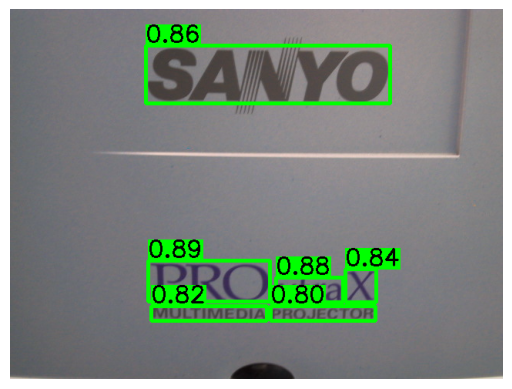

In [22]:
from ultralytics import YOLO 

model_path = "runs/detect/train5/weights/best.pt"
img_path = "datasets\SceneTrialTrain\lfsosa_12.08.2002\IMG_2588.JPG"
conf_thres = 0.75
model = YOLO(model_path)

results = model(img_path, verbose=False)
predictions = json.loads(results[0].to_json())
visualized_img = visualize_bbox(img_path, predictions, conf_thres)

%matplotlib inline 
plt.imshow(visualized_img)
plt.axis("off")
plt.show()